In [1]:
import functools
import math
import numpy as np
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
sns.set_style("white")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)

from IPython.display import display

### Load Database

In [2]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [3]:
db = DB('earthfury-alliance', timerange=21)

In [4]:
item = 2840 # copper bar

### Percentile Functions

In [5]:
def pctBelowValue(series, value):
    return stats.percentileofscore(series, value)/100

def pctAboveValue(series, value):
    return 1-stats.percentileofscore(series, value)/100

def valueAtPctile(series, pctile):
    return series.quantile(pctile)
    

### Daily Rollups

In [6]:
def dailyMax(item, column='minBuyout'):
    # use pctile instead of max() to avoid outliers, and tweak demand assumptions
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.75)

def dailyMin(item, column='minBuyout'):
    # use pctile instead of min() to avoid outliers
    df = db.get_df(item)
    return df.groupby(by=df['scannedAt'].dt.date)[column].quantile(.25)

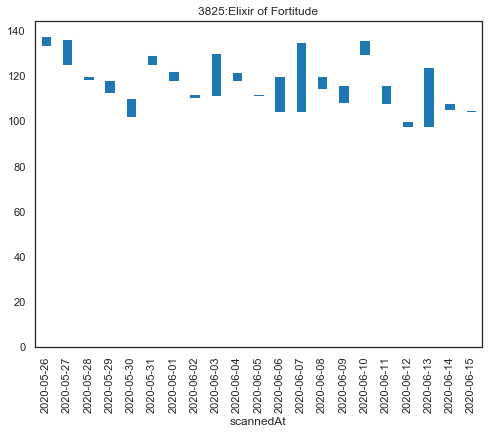

In [7]:
def plotDailyRange(item, buyAt=None, sellAt=None):
    title = f'{item}:{db.get_name(item)}'
        
    # create bars
    _, ax = plt.subplots()
    dailyMax(item).plot(kind='bar', x='scannedAt', y='minBuyout', title=title, ax=ax)
    dailyMin(item).plot(kind='bar', x='scannedAt', y='minBuyout', color='w', ax=ax)
    
    # add buy lines if passed
    if buyAt and sellAt:
        ax.axhline(y=buyAt, color='red')
        ax.axhline(y=sellAt, color='green')

    
plotDailyRange(3825)

### Analysis

In [9]:
def postcost_at_salerate(item, salerate):
    if salerate == 0:
        return 0
    vp = db.get_vendorprice(item) # double check this value is working correctly using in game reference 
    return (1-salerate) / salerate * (.6*vp)

def iterPrice(item, steps=100):
    # iterate from min price to max price in .01 percentile steps
    for pctile in np.arange(0, 1, 1.0/steps):
        yield db.get_df_hourly(item)['minBuyout'].quantile(pctile)

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,roi,flipRate,daysToFlip,flipsToDouble,daysToDouble,exclude
34,3825,Elixir of Fortitude,119.9812,0.571429,0.495,113.98214,104.3225,0.450304,9.16464,0.087434,0.257317,3.886261,8.269371,32.136937,False


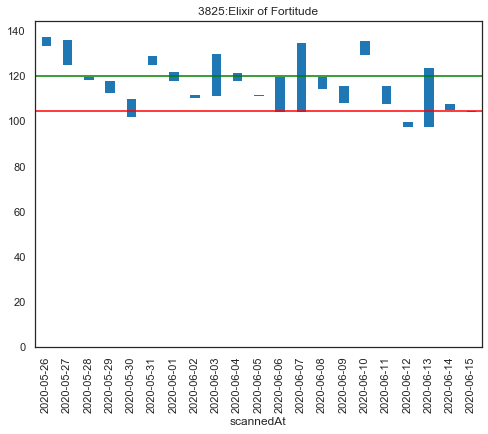

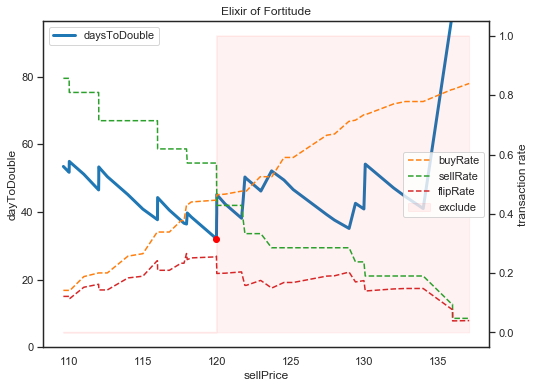

In [10]:
def analysis(item, show=False):
    data = []
    for sellPrice in iterPrice(item):
        # use pct of days above sellPrice to approx sellRate 
        sellRate = pctAboveValue(dailyMax(item), sellPrice)

        # expected posting cost based on sellRat
        postCost = postcost_at_salerate(item, sellRate)

        # maxBuy is limited by the AH cut
        maxBuy   = sellPrice * .95 
        
        # meanBuy is the average price below the maxBuy
        meanBuy  = db.get_df_hourly(item).query('minBuyout <= @maxBuy')['minBuyout'].mean()
        
        # use pct of hours below maxBuy to approx BuyRate
        buyRate  = pctBelowValue(db.get_df_hourly(item)['minBuyout'], maxBuy) 

        # value of sell after AH cut, post cost, and purchase price
        value = sellPrice*.95 - meanBuy - postCost
        
        # pct return based on purchase cost
        roi = value / (meanBuy + postCost)
        
        # discard records with negative margin or 0% rates
        if sellRate==0 or buyRate<.1 or roi<=0:
            continue
            
        # days to flip based on both sellRate and buyRate
        daysToFlip = 1 /(sellRate * buyRate)  # to do - change to expectation equation
        
        # flips to double based on roi of single flip
        flipsToDouble = math.log(2) / math.log(1+roi)
        
        # daysToDouble based on daysToFlip and FlipsToDouble
        daysToDouble = daysToFlip * flipsToDouble
        
        # load into data
        data.append({
            'item_id'  :item,
            'name'     :db.get_name(item),
            'sellPrice':sellPrice,
            'sellRate' :sellRate, 
            'postCost' :postCost,
            'maxBuy'   :maxBuy, 
            'meanBuy'  :meanBuy,
            'buyRate'  :buyRate,
            'value'    :value, 
            'roi'      :roi,
            'flipRate' :sellRate * buyRate,
            'daysToFlip'   :daysToFlip, 
            'flipsToDouble':flipsToDouble,
            'daysToDouble' :daysToDouble
        })

    # data frame for analysis
    df = pd.DataFrame(data)    
    
    df['exclude'] = df['sellRate'] < df['buyRate']
    
    # only consider sellRate > buyRate, so inventory clears rather sits at restock
    best = df.loc[df['daysToDouble'] == df.loc[~df['exclude']]['daysToDouble'].min()] # to do - what about multi matches
    
    if show:
        # plot daily range and best buy/sell lines
        display(best)
        plotDailyRange(item, best.iloc[0]['meanBuy'], best.iloc[0]['sellPrice'])
        
        # plot analysis curve
        _, ax = plt.subplots()        
        df.plot(x='sellPrice', y=['daysToDouble'], title=db.get_name(item), linewidth=3, ax=ax)
        ax.set_ylim(0, best.iloc[0]['daysToDouble']*3)
        plt.plot(best['sellPrice'],best['daysToDouble'],'ro') 
        
        # create exclusion zone based on flipate
        df['exclude'] = df['exclude'].astype(int)
        df.plot(kind='area', x='sellPrice', y='exclude', secondary_y=True, color='red', alpha=.05, ax=ax, legend=False)        
                
        # plot buy, sell, and flip rates
        df.plot(x='sellPrice', y=['buyRate', 'sellRate', 'flipRate'], style='--', secondary_y=True, ax=ax, legend=False).legend(loc='center right')
        ax.set_ylabel('dayToDouble')
        ax.right_ax.set_ylabel('transaction rate')
        return #df.round(2)
    return best.to_dict('r')[0]
    
analysis(3825, show=True)

### Full Run

In [11]:
%run ITEMS.ipynb


loaded
  herbs       : 30 items
  cloth       : 12 items
  mining      : 27 items
  enchant     : 24 items
  skinning    : 11 items
  meat        : 27 items
  consumables : 44 items
  eng         : 53 items
  ALL         : 228 items



In [12]:
%%time

# a bunch of printing and error catching, to simply map(fn, list_of_items)
def run_analysis(list_of_items, fn):
    print(f'running for {len(list_of_items)} items')    
    results = []    
    for i, item in enumerate(list_of_items):       
        # catch no data errors with try/except
        try:
            results.append(fn(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')
        # print progress
        if i%10 ==0: print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results).round(2)

df = run_analysis(ALL, analysis)

running for 228 items
 ...0 done
 ...10 done
 ...20 done
! ERROR - 13464, Golden Sansam
 ...30 done
 ...40 done
 ...50 done
 ...60 done
! ERROR - 17771, Elementium Bar
! ERROR - 3861, Blacksteel Bar
 ...70 done
 ...80 done
 ...90 done
! ERROR - 20725, Nexus Crystal
 ...100 done
! ERROR - 8169, Thick Hide
! ERROR - 1081, Crisp Spider Meat
 ...110 done
 ...120 done
! ERROR - 5467, Kodo Meat
 ...130 done
 ...140 done
! ERROR - 20748, Brilliant Mana Oil
! ERROR - 20749, Brilliant Wizard Oil
! ERROR - 21546, Elixir of Greater Firepower
 ...150 done
 ...160 done
 ...170 done
! ERROR - 21023, Dirge's Kickin' Chimaerok Chops
! ERROR - 16000, Thorium Tube
! ERROR - 12804, Powerful Mojo
 ...180 done
! ERROR - 16006, Delicate Arcanite Converter
 ...190 done
 ...200 done
 ...210 done
! ERROR - 4399, Wooden Stock
! ERROR - 4400, Heavy Stock
 ...220 done
! ERROR - 8150, Deeprock Salt
COMPLETE
Wall time: 6min 16s


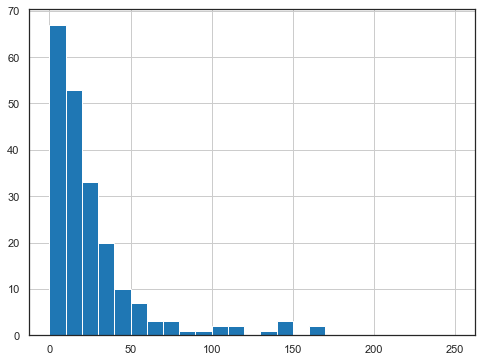

In [13]:
df['daysToDouble'].hist(bins=25, range=(0,250))

In [14]:
# set quantity by using hourly average
df['quantity'] = df['item_id'].apply(lambda x : int(db.get_df_hourly(x)['quantity'].mean()))

In [15]:
# set restock, based on 100x sungrass restock
scalar = df.query('name == "Sungrass"')['quantity'].iloc[0]
df['restock'] = (110 * df['quantity'] / scalar).astype(int)

df.head()

,item_id,name,sellPrice,sellRate,postCost,maxBuy,meanBuy,buyRate,value,roi,flipRate,daysToFlip,flipsToDouble,daysToDouble,exclude,quantity,restock
0,8153,Wildvine,113.99,0.71,0.01,108.29,98.41,0.38,9.87,0.10,0.27,3.73,7.25,27.05,False,161,53
1,8836,Arthas' Tears,5.60,0.67,0.29,5.32,4.40,0.61,0.63,0.13,0.41,2.46,5.50,13.52,False,109,35
2,13468,Black Lotus,14600.00,0.43,8.00,13870.00,12785.29,0.42,1076.71,0.08,0.18,5.57,8.58,47.80,False,21,6
3,13466,Plaguebloom,255.00,0.67,0.75,242.25,229.69,0.35,11.81,0.05,0.23,4.30,13.86,59.61,False,301,99
4,13465,Mountain Silversage,145.98,0.57,0.68,138.68,128.74,0.47,9.27,0.07,0.27,3.72,10.02,37.27,False,439,144


### Create Choice

In [16]:
# pretty prints a filter query
def filterFn(df, qstr, prefix='', show=False):
    removed = df.query(qstr)
    print(f'{prefix} -- Removing {len(removed)} of {len(df)} rows \n{removed["name"].to_list()}\n')
    if show:
        display(removed)
    
    # beautifully hacky way to do set difference of dataframes 
    return pd.concat([df, removed, removed]).drop_duplicates(keep=False)


def filterMinQuantity(df, minQuantity=100, show=False):
    return filterFn(df, f'quantity < {minQuantity}', prefix='Quantity Filter', show=show)

def filterMinPrice(df, minPrice=2, show=False):
    return filterFn(df, f'sellPrice < {minPrice}', prefix='Price Filter', show=show)

def filterMinDoubling(df, minDoubling=60, show=False):
    return filterFn(df, f'daysToDouble > {minDoubling}', prefix='Doubling Filter', show=show)

choice = df.copy()
choice = filterMinQuantity(choice, 90)
choice = filterMinPrice(choice, 2)
choice = filterMinDoubling(choice, 60)

Quantity Filter -- Removing 118 of 211 rows 
['Black Lotus', 'Grave Moss', 'Felcloth', 'Mooncloth', 'Bolt of Linen Cloth', 'Bolt of Woolen Cloth', 'Bolt of Mageweave', 'Bolt of Runecloth', 'Incendicite Ore', 'Silver Ore', 'Indurium Ore', 'Gold Ore', 'Truesilver Ore', 'Elementium Ore', 'Arcanite Bar', 'Dark Iron Bar', 'Enchanted Thorium Bar', 'Greater Magic Essence', 'Lesser Astral Essence', 'Greater Astral Essence', 'Lesser Mystic Essence', 'Greater Mystic Essence', 'Greater Nether Essence', 'Large Glimmering Shard', 'Small Glowing Shard', 'Large Glowing Shard', 'Small Radiant Shard', 'Large Radiant Shard', 'Small Brilliant Shard', 'Light Hide', 'Medium Hide', 'Heavy Hide', 'Rugged Hide', 'Tough Condor Meat', 'Mystery Meat', 'Tiger Meat', 'Red Wolf Meat', 'Heavy Kodo Meat', 'White Spider Meat', 'Tender Crab Meat', 'Sandworm Meat', 'Stringy Wolf Meat', 'Coyote Meat', 'Crawler Meat', 'Crocolisk Meat', 'Bear Meat', 'Tender Crocolisk Meat', 'Big Bear Meat', 'Lion Meat', 'Giant Clam Meat', 

In [17]:
pd.set_option('display.max_rows', None)
cols = ['item_id', 'name', 'sellPrice', 'meanBuy', 'sellRate', 'buyRate', 'roi', 'daysToFlip', 'daysToDouble']
display(choice.sort_values(by='daysToDouble')[cols])

,item_id,name,sellPrice,meanBuy,sellRate,buyRate,roi,daysToFlip,daysToDouble
119,5503,Clam Meat,2.86,1.37,0.76,0.43,0.95,3.04,3.16
68,11137,Vision Dust,6.00,3.57,0.67,0.64,0.60,2.34,3.47
81,10978,Small Glimmering Shard,2.48,1.31,0.71,0.47,0.80,2.96,3.49
8,2453,Bruiseweed,3.33,2.01,0.67,0.55,0.52,2.75,4.54
66,10940,Strange Dust,2.90,1.77,0.57,0.56,0.56,3.15,4.92
177,2836,Coarse Stone,8.94,5.43,0.90,0.34,0.56,3.21,5.00
67,11083,Soul Dust,18.88,12.04,0.62,0.53,0.49,3.03,5.26
45,2770,Copper Ore,3.51,2.33,0.81,0.44,0.43,2.78,5.41
92,2319,Medium Leather,2.02,1.31,0.76,0.47,0.36,2.80,6.28
54,2842,Silver Bar,14.99,10.25,0.76,0.43,0.36,3.04,6.78


### Inspect Results

In [18]:
choice['coefVar'] = (choice['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].std()) / 
                     choice['item_id'].apply(lambda x: db.get_df_hourly(x)['minBuyout'].mean())
                    )

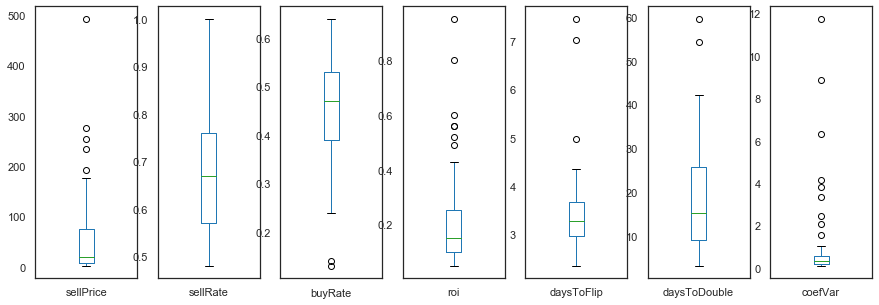

In [19]:
def boxPlots(df, cols, showfliers=True):
    fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=len(cols))    
    for i in range(len(cols)):
        choice.plot(kind='box', y=cols[i], showfliers=showfliers, ax=axes[i])

cols = ['sellPrice', 'sellRate', 'buyRate', 'roi', 'daysToFlip', 'daysToDouble', 'coefVar']
boxPlots(choice, cols)

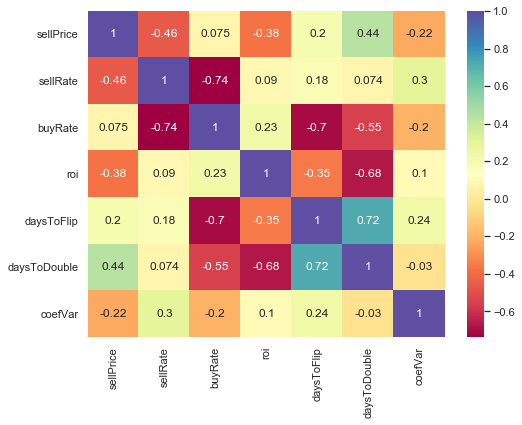

In [20]:
tcorr = choice[cols].corr()
sns.heatmap(tcorr, xticklabels=tcorr.columns, yticklabels=tcorr.columns, annot=True, cmap="Spectral")

### Export

In [21]:
%run EXPORT.ipynb

 
Usage:
  EXPORT(dataframe) --> expects df with specific columns
                          name         - required, string
                          item_id      - required, integer
                          buy_price    - required, integer in copper
                          min_price    - required, integer in copper 
                          normal_price - required, integer in copper
                          max_price    - required, integer in copper
                          restock      - optional, default 20
  example_export_input()  --> shows expected data schema
  example_export_output() --> shows output of example data



In [22]:
def get_export(df, max_buy_pct=.95):
    # max_buy_pct default at 95% due to 5% auction house cut
    e = df.copy()
    
    # format for export (note, 100x to scale integer copper)
    e['name'] = e.apply(lambda row: f"{int(100*row['sellRate'])}sr_{int(row['restock'])}stock_{row['name']}", axis=1)
    e['buy_price']    = 100 * e['sellPrice'] * max_buy_pct 
    e['min_price']    = 100 * e['sellPrice']
    e['normal_price'] = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
    e['max_price']    = 100 * e['sellPrice'] * 1.1 # bit more profit when lowest post, but don't hurt saleRate
    e = e.astype({'buy_price':int, 'min_price':int, 'normal_price':int, 'max_price':int})
    
    # stack_size=10 if item price is less than 1g, else stack_size=5
    e['stack_size'] = e['sellPrice'].apply(lambda x: 20 if x < 100 else 5)
    
    EXPORT(e)
    return e
e = get_export(choice, .95)

^1^T^Soperations^T^SMailing^T^S#Default^T^Srestock^b^SkeepQty^N0^SmaxQtyEnabled^b^Starget^S^SrestockSources^T^Sguild^b^Sbank^b^t^SmaxQty^N10^t^t^SAuctioning^T^Ss71sr_53stock_Wildvine^T^SaboveMax^SmaxPrice^SnormalPrice^S12539^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N5^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S12539^SignoreLowDuration^N0^SstackSize^N1^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S11400^SkeepQtySources^T^t^Sblacklist^S^t^SS71sr_53stock_Wildvine^T^SaboveMax^SmaxPrice^SnormalPrice^S12538^Sduration^N3^SmatchStackSize^b^SkeepQuantity^N0^SpostCap^N20^SbidPercent^N1^SstackSizeIsCap^B^SmaxPrice^S12538^SignoreLowDuration^N0^SstackSize^N5^SkeepPosted^N0^Sundercut^S1c^SmaxExpires^N0^SpriceReset^SminPrice^ScancelRepostThreshold^S1g^ScancelRepost^B^ScancelUndercut^B^SminPrice^S11399^SkeepQtySources^T^t^Sblacklist^S^t^Ss67sr_35stock_Arthas' Tears^T^SaboveMax^SmaxPrice^Snormal